# One-shot Sleep Stage Classification Deep learning model using CNN-LSTM

### Installing additional libraries for Colab

In [4]:
# !pip install mne

### Importing libraries

In [5]:
import mne
import os
import io
import scipy.io as scio
from scipy import signal
import numpy as np
from google.colab import drive
import torch
import gc
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks, RandomUnderSampler
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D, Flatten, LSTM, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import tensorflow as tf
import keras
from tensorflow.keras.utils import Sequence
import numpy as np  
import math 
from sklearn import metrics

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
keras.backend.set_session(sess)

tf.random.set_seed(1)
epochs = 40

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [6]:
channels = ['C3_A2', 'C4_A1', 'F3_A2', 'F4_A1', 'O1_A2', 'O2_A1']
drive_path = 'CS7643-FinalProject/'

## One-time pre-processing

This process is to Download the data from the ISRUC-SLEEP extracted channel dataset which has the MAT files and the .rar datasets which has the label information.<br>
This is a one-time setup process to generate a compressed multi-array numpy .npz file which has the raw data in the ExCxT format where E is the number of epochs, C is the number of channels and T is the sequence of values recorded at different timesteps. This object also has the label information for both the reviewers and the length of epochs for each fold.  

In [7]:
%%capture

# Set this to true to generate and save a new .NPZ data extract after processing
EXTRACT_NPZ_FILE = False

def read_eeg_data(file_path, subject_id, channel_list, resample=3000):
    eeg_raw = scio.loadmat(os.path.join(file_path, 'rawdata', f'subject{subject_id}.mat'))
    appended_eeg = []
    for c in channel_list:
        appended_eeg.append(
            np.expand_dims(signal.resample(eeg_raw[c], resample, axis=-1), 1))
    appended_eeg = np.concatenate(appended_eeg, axis=1)
    return appended_eeg

def read_eeg_datalabel(file_path, subject_id, reviewer):
    label = []
    with open(os.path.join(file_path, 'labeldata', f'{subject_id}/{subject_id}_{reviewer}.txt')) as f:
        s = f.readline()
        while True:
            a = s.replace('\n', '')
            label.append(int(a))
            s = f.readline()
            if s == '' or s == '\n':
                break
    return np.array(label[:-30])

if EXTRACT_NPZ_FILE:
  # Create temporary directories in Colab
  !mkdir CS7643-FinalProject
  !mkdir CS7643-FinalProject/rawdata
  !mkdir CS7643-FinalProject/labeldata

  # Downloading Label data
  for i in range(1,101):
    !wget --directory-prefix=CS7643-FinalProject/labeldata http://dataset.isr.uc.pt/ISRUC_Sleep/subgroupI/{i}.rar
    !unrar x -o+ CS7643-FinalProject/labeldata/{i}.rar CS7643-FinalProject/labeldata/
    !rm CS7643-FinalProject/labeldata/{i}.rar

  # Downloading MAT raw data
  for i in range(1,101):
    !wget --directory-prefix=CS7643-FinalProject/rawdata http://dataset.isr.uc.pt/ISRUC_Sleep/ExtractedChannels/subgroupI-Extractedchannels/subject{i}.mat  

  # Extracting, formatting and storing tensors and arrays for raw data and label data for each fold/group/subject
  data_group = []
  label_group = []
  len_group = []

  for sub in range(1,101):
    label_reviewer_1 = read_eeg_datalabel(drive_path, sub, 1)
    label_reviewer_2 = read_eeg_datalabel(drive_path, sub, 2)
    eeg = read_eeg_data(drive_path, sub, channels)

    label_reviewer_1[label_reviewer_1==5] = 4
    label_reviewer_2[label_reviewer_2==5] = 4

    equal_label = label_reviewer_1[label_reviewer_1==label_reviewer_2]

    label_group.append(equal_label)

    data_group.append(eeg[label_reviewer_1==label_reviewer_2])
    len_group.append(len(label_reviewer_1)) 

  # Saving the entire struct as a single .npz compressed file
  np.savez_compressed(os.path.join(drive_path, 'ISRUC_PROCESSED_DATA_FINAL.npz'),
      DATA_GROUP = data_group,
      LABEL_GROUP = label_group,
      LEN_GROUP = len_group
  )

  # Saving the .npz file in GDrive
  drive.mount('/content/drive')
  !cp CS7643-FinalProject/ISRUC_PROCESSED_DATA_FINAL.npz drive/MyDrive/CS-7643-FinalProject/ISRUC_PROCESSED_DATA_FINAL.npz

## Importing and setting up the Data

Copying the NPZ file from the GDrive to local Colab env - Run for the first time to fetch the data npz file

In [8]:
drive.mount('/content/drive')
!mkdir CS7643-FinalProject
!cp /content/drive/MyDrive/CS-7643-FinalProject/ISRUC_PROCESSED_DATA_FINAL.npz CS7643-FinalProject/ISRUC_PROCESSED_DATA_FINAL.npz

Mounted at /content/drive


In [41]:
npz_object = np.load(os.path.join(drive_path, 'ISRUC_PROCESSED_DATA_FINAL.npz'), allow_pickle=True)

data_group = npz_object['DATA_GROUP']
label_group = npz_object['LABEL_GROUP']
len_group = npz_object['LEN_GROUP']

In [42]:
# Removing the 17th index subject - Not sure why but on input the data is of size 0 for the 17th subject. So just ignoring the 600 entries for this subject
data_group = np.delete(data_group, 17)
label_group = np.delete(label_group, 17)

In [43]:
X = np.vstack(data_group)
y = np.hstack(label_group)

In [44]:
# Reshaping the input data from (Epochs, Channels, Timestamps) to (Epochs, Timestamps, Channels) for Keras format
X = np.moveaxis(X, 1, 2)
X.shape, y.shape

((70595, 3000, 6), (70595,))

In [45]:
# Removing npz data groups from memory
del data_group, label_group, len_group

In [46]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

In [47]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((56476, 3000, 6), (56476,), (7059, 3000, 6), (7059,))

In [48]:
del X, y

Text(0.5, 1.0, 'Distribution of Sleep stages (Training data)')

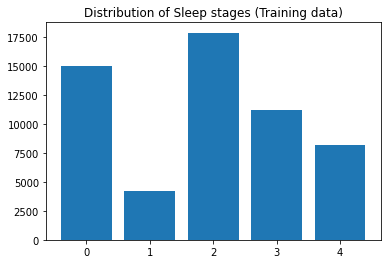

In [49]:
# Oversampling using SMOTE only on the Training data
plt.bar(Counter(y_train).keys(), Counter(y_train).values())
plt.title("Distribution of Sleep stages (Training data)")

(57297, 3000, 6) (57297,)


Text(0.5, 1.0, 'Distribution of Sleep stages (After SMOTE oversampling')

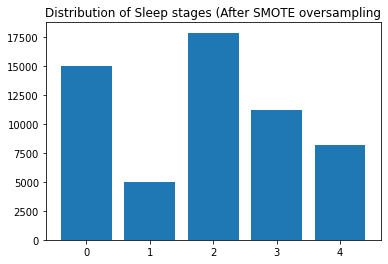

In [50]:
# Oversampling minority class only using SMOTE on training data

oversample = SMOTE(sampling_strategy={1:5000}, n_jobs=-1)
# undersample = RandomUnderSampler(sampling_strategy={0:12500,2:13000})
orig_shape = X_train.shape
X_train = X_train.reshape(len(X_train), -1)
Xo, yo = oversample.fit_resample(X_train, y_train)
# Xo, yo = undersample.fit_resample(Xo, yo)

del X_train, y_train

X_train = Xo.reshape(-1, *orig_shape[1:])
y_train = yo

del Xo, yo

print(X_train.shape, y_train.shape)
plt.bar(Counter(y_train).keys(), Counter(y_train).values())
plt.title("Distribution of Sleep stages (After SMOTE oversampling")

In [51]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(57297, 3000, 6) (57297,) (7059, 3000, 6) (7059,)


## Deep learning model training (Keras)

In [52]:
cnnLstmModel = Sequential()
cnnLstmModel.add(Conv1D(12, 2, activation='relu',name = 'base1',input_shape=(3000,6), padding='same'))
cnnLstmModel.add(Conv1D(12, 2, activation='relu',name = 'base2', padding='same'))
cnnLstmModel.add(Conv1D(12, 2, activation='relu',name = 'base3', padding='same'))
cnnLstmModel.add(MaxPool1D(2,2))

cnnLstmModel.add(Conv1D(24, 4, activation='relu',name = 'base4', padding='same'))
cnnLstmModel.add(Conv1D(24, 4, activation='relu',name = 'base5', padding='same'))
cnnLstmModel.add(Conv1D(24, 4, activation='relu',name = 'base6', padding='same'))
cnnLstmModel.add(MaxPool1D(2,2))

cnnLstmModel.add(Conv1D(48, 6, activation='relu',name = 'base7', padding='same'))
cnnLstmModel.add(Conv1D(48, 6, activation='relu',name = 'base8', padding='same'))
cnnLstmModel.add(Conv1D(48, 6, activation='relu',name = 'base9', padding='same'))
cnnLstmModel.add(MaxPool1D(2,2))

cnnLstmModel.add(Conv1D(96, 8, activation='relu',name = 'base10', padding='same'))
cnnLstmModel.add(Conv1D(96, 8, activation='relu',name = 'base11', padding='same'))
cnnLstmModel.add(Conv1D(96, 8, activation='relu',name = 'base12', padding='same'))
cnnLstmModel.add(MaxPool1D(2,2))

cnnLstmModel.add(LSTM(12, return_sequences=True))
cnnLstmModel.add(LSTM(12))

cnnLstmModel.add(Flatten(name = 'flatten'))
cnnLstmModel.add(Dense(1024))
cnnLstmModel.add(Dense(512))
cnnLstmModel.add(Dense(5))

In [53]:
cnnLstmModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base1 (Conv1D)              (None, 3000, 12)          156       
                                                                 
 base2 (Conv1D)              (None, 3000, 12)          300       
                                                                 
 base3 (Conv1D)              (None, 3000, 12)          300       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1500, 12)         0         
 1D)                                                             
                                                                 
 base4 (Conv1D)              (None, 1500, 24)          1176      
                                                                 
 base5 (Conv1D)              (None, 1500, 24)          2328      
                                                      

In [54]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.80)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

cnnLstmModel.compile('adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [55]:
# Data generator to load small batches for Keras
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.indices = np.arange(self.x.shape[0])

    def __len__(self):
        return math.ceil(self.x.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[inds]
        batch_y = self.y[inds]
        return batch_x, batch_y
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)        

train_gen = DataGenerator(X_train, y_train, 128)
valid_gen = DataGenerator(X_valid, y_valid, 128)
test_gen = DataGenerator(X_test, y_test, 128)

In [56]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))

In [57]:
# This callback will stop the training when there is no improvement in the loss for three consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = cnnLstmModel.fit(train_gen,epochs=epochs,validation_data=valid_gen, callbacks=[callback], class_weight=class_weights)

Epoch 1/40
448/448 [==============================] - 35s 68ms/step - loss: 1.1522 - accuracy: 0.5293 - val_loss: 1.0296 - val_accuracy: 0.5512
Epoch 2/40
448/448 [==============================] - 29s 65ms/step - loss: 0.8663 - accuracy: 0.6624 - val_loss: 0.7656 - val_accuracy: 0.6900
Epoch 3/40
448/448 [==============================] - 29s 65ms/step - loss: 0.7621 - accuracy: 0.7157 - val_loss: 0.6318 - val_accuracy: 0.7586
Epoch 4/40
448/448 [==============================] - 29s 65ms/step - loss: 0.6878 - accuracy: 0.7591 - val_loss: 0.6399 - val_accuracy: 0.7575
Epoch 5/40
448/448 [==============================] - 29s 65ms/step - loss: 0.6406 - accuracy: 0.7818 - val_loss: 0.5278 - val_accuracy: 0.8034
Epoch 6/40
448/448 [==============================] - 29s 65ms/step - loss: 0.6145 - accuracy: 0.7921 - val_loss: 0.5587 - val_accuracy: 0.7967
Epoch 7/40
448/448 [==============================] - 29s 65ms/step - loss: 0.5809 - accuracy: 0.8015 - val_loss: 0.5225 - val_accuracy:

In [58]:
cnnLstmModel.evaluate(test_gen)

56/56 [==============================] - 1s 25ms/step - loss: 0.3862 - accuracy: 0.8673


[0.3861566185951233, 0.8672804236412048]

In [69]:
cnnLstmModel.save("drive/MyDrive/CS-7643-FinalProject/cnnLstmModel_87pct_FINAL")

INFO:tensorflow:Assets written to: drive/MyDrive/CS-7643-FinalProject/cnnLstmModel_87pct_FINAL/assets


INFO:tensorflow:Assets written to: drive/MyDrive/CS-7643-FinalProject/cnnLstmModel_87pct_FINAL/assets


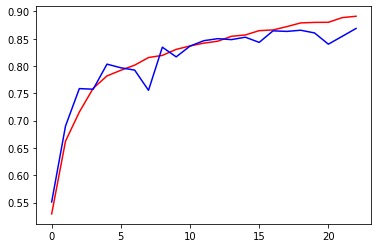

In [60]:
plt.plot(history.history['accuracy'], 'r', history.history['val_accuracy'], 'b')

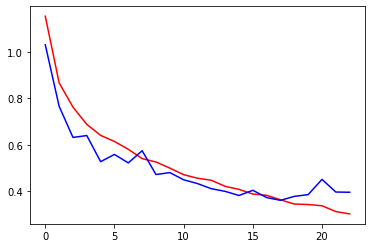

In [61]:
plt.plot(history.history['loss'], 'r', history.history['val_loss'], 'b')

In [62]:
y_pred = cnnLstmModel.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

In [63]:
metrics.confusion_matrix(y_pred, y_test)

array([[1693,   20,   11,    1,   10],
       [ 163,  340,  155,    1,   81],
       [  20,   82, 2020,  135,   41],
       [   0,    0,   76, 1230,    0],
       [  12,   73,   56,    0,  840]])

In [64]:
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.8967161 , 0.66019417, 0.8714409 , 0.89978054, 0.86419753])

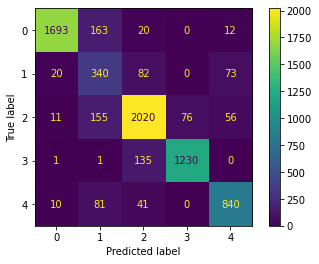

In [65]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.90      0.93      1888
           1       0.46      0.66      0.54       515
           2       0.88      0.87      0.88      2318
           3       0.94      0.90      0.92      1367
           4       0.86      0.86      0.86       972

    accuracy                           0.87      7060
   macro avg       0.82      0.84      0.83      7060
weighted avg       0.88      0.87      0.87      7060



In [67]:
per_class_accuracies = {}

for idx, cls in enumerate([0,1,2,3,4]):
    # True negatives are all the samples that are not our current GT class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(matrix, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current GT class that were predicted as such
    true_positives = matrix[idx, idx]
    
    # The accuracy for the current class is ratio between correct predictions to all predictions
    per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(matrix)

In [68]:
per_class_accuracies

{0: 0.9664305949008498,
 1: 0.9185552407932012,
 2: 0.918413597733711,
 3: 0.9698300283286119,
 4: 0.9613314447592068}

In [37]:
# !pip3 install keras-visualizer
#

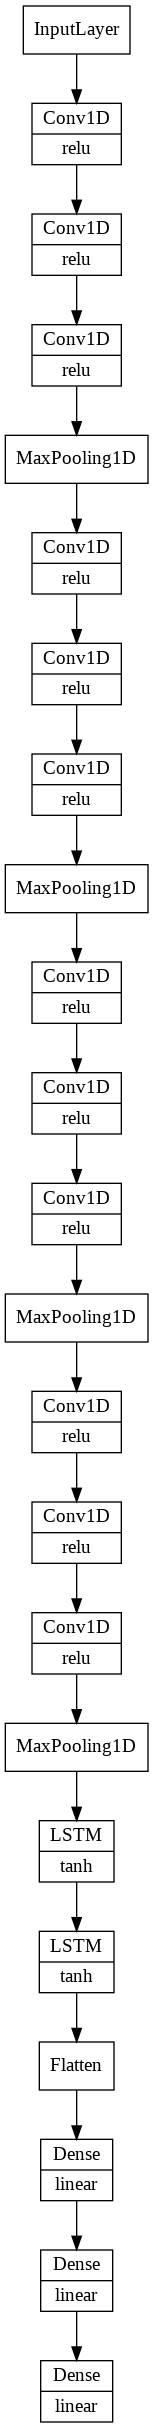

In [38]:
tf.keras.utils.plot_model(
    cnnLstmModel,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)